In [48]:
import numpy as np
import time
import os
import matplotlib.pyplot as plot

In [5]:
import kagglehub

path = kagglehub.dataset_download("hojjatk/mnist-dataset")

print("Path to dataset files:", path)

100%|██████████| 22.0M/22.0M [00:08<00:00, 2.73MB/s]

Extracting files...


Path to dataset files: /home/alexashw/.cache/kagglehub/datasets/hojjatk/mnist-dataset/versions/1


In [8]:
DATA_PATH = path

def MNISTDataset(path_to_images: os.PathLike, path_to_labels: os.PathLike):
    images, labels = "", ""
    with open(path_to_images, 'rb') as f:
        images = np.frombuffer(f.read(), np.uint8, offset=16)
        images = images.reshape(-1, 28*28)
        images = images / 255.0

    with open(path_to_labels, 'rb') as f:
        labels = np.frombuffer(f.read(), np.uint8, offset=8)

    return images, labels

train_images, train_labels = MNISTDataset(path_to_images=os.path.join(DATA_PATH, 'train-images.idx3-ubyte'),
                             path_to_labels=os.path.join(DATA_PATH, 'train-labels.idx1-ubyte'))

test_images, test_labels = MNISTDataset(path_to_images=os.path.join(DATA_PATH, 't10k-images.idx3-ubyte'),
                             path_to_labels=os.path.join(DATA_PATH, 't10k-labels.idx1-ubyte'))

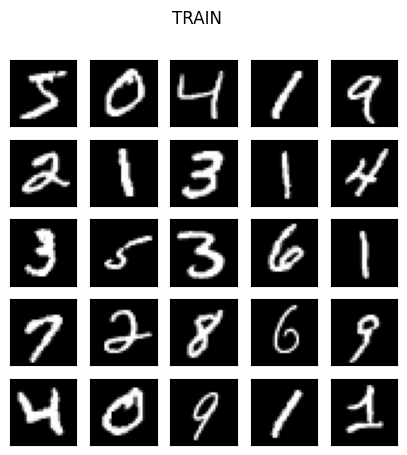

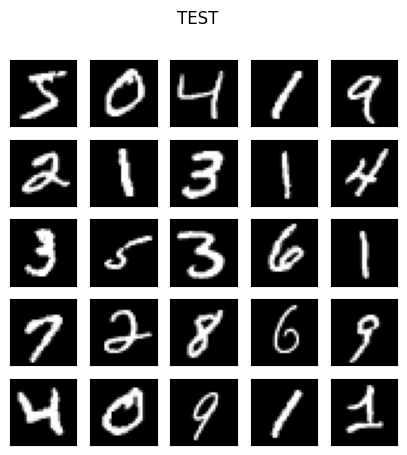

In [32]:
dir_name = os.getcwd()
batch_size = 128


def show_images(images, num_showed_imgs, title):
    figsize = (5, 5)
    fig, axes = plot.subplots(
        num_showed_imgs, num_showed_imgs, figsize=figsize)
    fig.suptitle(title)
    plot.setp(plot.gcf().get_axes(), xticks=[], yticks=[])
    for i, ax in enumerate(axes.flat):
        img = images[i].reshape(28, 28)
        ax.imshow(img, cmap='gray')

show_images(train_images, 5, "TRAIN")
show_images(train_images, 5, "TEST")

In [59]:
class FCNN():
    def __init__(self, epochs=20, lr=0.1, batch_size=22, hidden_size=300):
        self.batch_size = batch_size
        self.lr = lr
        self.epochs = epochs
        self.weights1 = np.random.randn(784, hidden_size) * np.sqrt(2.0/784)
        self.weights2 = np.random.randn(hidden_size, 10) * np.sqrt(2.0/hidden_size)
        self.bias1 = np.zeros((1, hidden_size))
        self.bias2 = np.zeros((1, 10))

    def generate(self, dataset, labels, shuffle=False):
        if len(dataset) != len(labels):
            raise ValueError("Length of dataset must be equal to length of labels.")
        
        indices = np.arange(len(labels))
        
        if shuffle:
            np.random.shuffle(indices)
        
        batch_num = len(labels) // self.batch_size
        for i in range(batch_num):
            batch_indices = indices[self.batch_size*i:self.batch_size*(i+1)]
            yield dataset[batch_indices], labels[batch_indices]

        # Для обработки последних данных, если они есть
        if len(labels) % self.batch_size != 0:
            batch_indices = indices[batch_num * self.batch_size:]
            yield dataset[batch_indices], labels[batch_indices]

    def relu(self, x):
        return np.maximum(0, x)
    
    def drelu(self, x):
        return np.where(x > 0, 1, 0)

    def softmax(self, x):
        exp_shifted = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return exp_shifted / np.sum(exp_shifted, axis=-1, keepdims=True)
    def forward(self, x):
        self.z1 = np.dot(x, self.weights1) + self.bias1
        self.a1 = self.relu(self.z1)
        self.z2 = np.dot(self.a1, self.weights2) + self.bias2
        self.a2 = self.softmax(self.z2)
        return self.a2

    def accuracy(self, data_loader, images1, labels1):
        tp = 0
        n = 0
        for images, labels in data_loader(images1, labels1):
            outputs = self.forward(images)

            predicted = np.argmax(outputs, axis=1)
            
            n += len(labels)
            tp += (predicted == labels).sum()
        return tp / n
    
    def cross_entropy_loss(self, outputs, targets):
        outputs = np.clip(outputs, 1e-12, 1. - 1e-12)
        return -np.sum(self.encode(targets) * np.log(outputs+1e-9)) / targets.shape[0]

    def encode(self, targets):
        arr = np.zeros((len(targets), 10))
        for i in range(len(targets)):
            arr[i][targets[i]] = 1.
        return arr
    
    def backward(self, inputs, outputs, targets):
        dL_dz2 = outputs - self.encode(targets)
        dL_dz2 = dL_dz2 / outputs.shape[0]

        dL_dw2 = np.dot(self.a1.T, dL_dz2)
        dL_db2 = np.sum(dL_dz2, axis=0, keepdims=True)

        dL_da1 = np.dot(dL_dz2, self.weights2.T)
        dL_dz1 = dL_da1 * self.drelu(self.z1)

        dL_dw1 = np.dot(inputs.T, dL_dz1)
        dL_db1 = np.sum(dL_dz1, axis=0, keepdims=True)

        self.weights1 -= self.lr * dL_dw1
        self.bias1 -= self.lr * dL_db1
        self.weights2 -= self.lr * dL_dw2
        self.bias2 -= self.lr * dL_db2

    def train(self, images, labels):
        for epoch in range(self.epochs):
            start_time = time.time()
            cross_entropy = 0.
            for batch_images, batch_labels in self.generate(images, labels):
                outputs = self.forward(batch_images)
                self.backward(batch_images, outputs, batch_labels)
                #cross_entropy += self.cross_entropy_loss(outputs, batch_labels)
            end_time = time.time()

            print(f"time of epoch {epoch+1} execution: {end_time-start_time} seconds")
            #print("cross_entropy: ", cross_entropy/len(labels))
            print("accuracy: ", self.accuracy(self.generate, images, labels))
    
    def test(self, images, labels):
        print("ACCURACY", self.accuracy(self.generate, images, labels))



In [63]:
jija = FCNN()
jija.train(train_images, train_labels)

time of epoch 1 execution: 8.939966440200806
accuracy:  0.9562166666666667
time of epoch 2 execution: 4.9697206020355225
accuracy:  0.97335
time of epoch 3 execution: 6.307349681854248
accuracy:  0.9808166666666667
time of epoch 4 execution: 4.761703014373779
accuracy:  0.9851166666666666
time of epoch 5 execution: 5.068265914916992
accuracy:  0.9879333333333333
time of epoch 6 execution: 4.82448410987854
accuracy:  0.9902666666666666
time of epoch 7 execution: 5.184183120727539
accuracy:  0.9919833333333333
time of epoch 8 execution: 5.408993482589722
accuracy:  0.99335
time of epoch 9 execution: 5.356000900268555
accuracy:  0.9940833333333333
time of epoch 10 execution: 10.18574833869934
accuracy:  0.9949333333333333
time of epoch 11 execution: 17.502755165100098
accuracy:  0.9954833333333334
time of epoch 12 execution: 10.41906189918518
accuracy:  0.9962166666666666
time of epoch 13 execution: 8.803355693817139
accuracy:  0.9964333333333333
time of epoch 14 execution: 9.102114200592

In [64]:
jija.test(test_images, test_labels)

ACCURACY 0.9807
